In [1]:
import os
import json
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

ModuleNotFoundError: No module named 'torch'

In [2]:
# 데이터 경로 설정
CLICKBAIT_DIR = "/kaggle/input/samplebait/Clickbait/EC"
NONCLICKBAIT_DIR = "/kaggle/input/samplebait/NonClickbait/EC"

In [3]:
# JSON 파일 로드 함수
def load_json_files(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
                content = json.load(f)
                title = content["sourceDataInfo"]["newsTitle"]
                label = content["labeledDataInfo"]["clickbaitClass"]
                data.append((title, label))
    return data

In [4]:
# 데이터 로드
clickbait_data = load_json_files(CLICKBAIT_DIR)
nonclickbait_data = load_json_files(NONCLICKBAIT_DIR)

In [5]:
# DataFrame 생성
df = pd.DataFrame(clickbait_data + nonclickbait_data, columns=["title", "label"])

In [6]:
# 데이터 분할
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["title"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

In [7]:
# BERT Tokenizer 로드
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [31]:
# 데이터셋 클래스 정의
class ClickbaitDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
        self.texts[idx],
        padding="max_length",
        truncation=True,
        max_length=self.max_len,
        return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [32]:
# 데이터로더 설정
train_dataset = ClickbaitDataset(train_texts, train_labels, tokenizer)
test_dataset = ClickbaitDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [33]:
# 모델 설정
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)# 옵티마이저 및 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# 옵티마이저 및 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [40]:
# 모델 학습
EPOCHS = 6
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

Epoch 1, Loss: 0.44006777789882834
Epoch 2, Loss: 0.3274800752930541
Epoch 3, Loss: 0.21193535043769463
Epoch 4, Loss: 0.13644239449866485
Epoch 5, Loss: 0.09781436894722849
Epoch 6, Loss: 0.08486610189869914


In [41]:
# 모델 평가
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [42]:
# 결과 출력
print("Accuracy:", accuracy_score(true_labels, predictions))
print("Classification Report:\n", classification_report(true_labels, predictions))

Accuracy: 0.6720532319391636
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.69      0.68       539
           1       0.67      0.65      0.66       513

    accuracy                           0.67      1052
   macro avg       0.67      0.67      0.67      1052
weighted avg       0.67      0.67      0.67      1052



In [48]:
# 모델을 평가 모드로 전환
model.eval()

# 토크나이저 로드 (미리 사용한 것과 동일한 모델로 로드)
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

def predict_clickbait(title):
    # 입력 데이터 토큰화
    inputs = tokenizer(title, padding=True, truncation=True, max_length=128, return_tensors="pt")
    
    # GPU 사용 가능하면 이동
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    # 모델 예측 수행
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 예측값 변환 (로직 → 확률 → 클래스)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    
    # 출력
    label_map = {0: "Non-Clickbait", 1: "Clickbait"}
    print(f"입력 제목: {title}")
    print(f"예측 결과: {label_map[predicted_class]} (확률: {probabilities.squeeze().tolist()})")

# 샘플 테스트
sample_titles = [
    "공공구매에 사회가치 본격 반영",
    "국민연금 못받는 20대",
    "이재명 중국 귀화, 리짜오밍으로 개명까지"
]

for title in sample_titles:
    predict_clickbait(title)


입력 제목: 공공구매에 사회가치 본격 반영
예측 결과: Non-Clickbait (확률: [0.9918630123138428, 0.008136944845318794])
입력 제목: 국민연금 못받는 20대
예측 결과: Non-Clickbait (확률: [0.9953082203865051, 0.004691801033914089])
입력 제목: 이재명 중국 귀화, 리짜오밍으로 개명까지
예측 결과: Clickbait (확률: [0.1932271271944046, 0.8067728877067566])


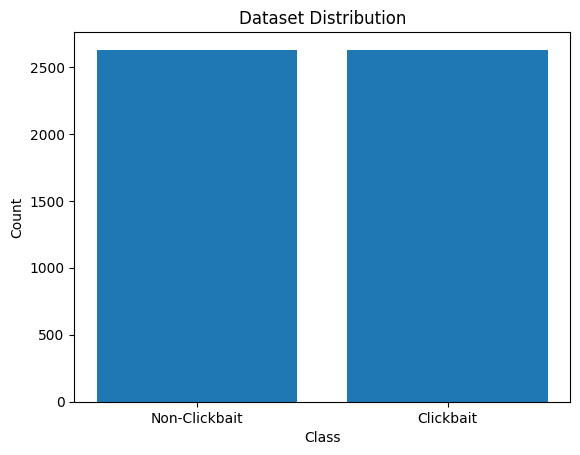

In [39]:
import matplotlib.pyplot as plt

# 데이터 라벨 분포 확인
label_counts = df["label"].value_counts()
plt.bar(["Non-Clickbait", "Clickbait"], label_counts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Dataset Distribution")
plt.show()

In [ ]:
# 저장할 경로
model_save_path = "python-api/model/clickbait_model.pt"
tokenizer_save_path = "python-api/tokenizer_dir"

# 모델 저장
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# 토크나이저 저장
tokenizer.save_pretrained(tokenizer_save_path)
print(f"Tokenizer saved to {tokenizer_save_path}")